## Методические указания по выполнению лабораторной работы №3

**Тема: Обнаружение объектов с использованием Faster R-CNN**

**Цель работы:** Ознакомиться с архитектурой Faster R-CNN и принципами двухэтапного обнаружения объектов.

**Задачи:**
- Изучить теоретические основы двухэтапного обнаружения объектов: роль RPN и классификационного этапа в Faster R-CNN.
- Загрузить предобученную модель Faster R-CNN.
- Ознакомиться с форматом аннотаций для обучения в задаче детекции.
- Визуализировать предсказания, проанализировать ошибки модели и провести исследование по поиску баланса FN/FP.

### 1. Теоретическая часть

В данной лабораторной работе мы познакомимся с задачей детекции на примере архитектуры [Faster R-CNN](https://arxiv.org/pdf/1506.01497), обученной на наборе данных [COCO](https://cocodataset.org/#home), а также с новым форматом данных для обучения нейро-сетевых моделей детекции. Для оценки модели воспользуемся набором данных [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/).

**Перед тем, как приступать к выполнению практической части, ознакомьтесь с первоисточниками используемых компонентов, а также документацией по [ссылке](https://pytorch.org/vision/master/models/faster_rcnn.html), включающей подробности работы с моделью и новым форматом данных, сэмплы кода.**

#### 1.1 Архитектура Faster R-CNN

Существует два основных подхода к обнаружению объектов:
Двухстадийные модели – более точные, но медленные.
Одностадийные модели – быстрые, но менее точные.

Faster R-CNN — это двухэтапная модель детекции объектов. В отличие от ResNeXt, Faster R-CNN не просто классифицирует изображение, а находит на нём несколько объектов, предсказывает bounding boxes и присваивает метки классам. Она состоит из следующих компонентов:

1. Backbone (ResNet/VGG/MobileNet) – извлекает признаки из изображения.
2. Region Proposal Network (RPN) – предлагает области, где могут находиться объекты.
3. ROI Pooling + Fully Connected Layers – классифицирует объекты и уточняет bounding boxes.
4. Non-Maximum Suppression (NMS) – убирает дублирующиеся предсказания.


В предыдущих лабораторных работах мы познакомились с классификацией изображений, где модель предсказывает единственный класс для всего изображения. Однако во многих задачах компьютерного зрения классификация недостаточна. Например, когда на одном изображении присутствуют несколько объектов разных классов необходимо не только определить, что изображено, но и где это находится.

Faster R-CNN –  модель, которая также решает задачу обнаружения объектов, добавляя к классификации локализацию.

#### 1.2 Формат данных для задачи детекции

Faster R-CNN требует разметки изображений, помимо классов включающей в себя и координаты bounding box по оси x, y.
Ознакомьтесь с форматом набора данных Pascal VOC, скачайте аннотации набора данных и изучите структуру **.xml** файлов в папке Annotations по [ссылке](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtestnoimgs_06-Nov-2007.tar).

#### 1.3 Оценка качества

Помимо известных вам инструментов оценить качество работы детектора могут помочь:

Confidence Score - значение, указывающее на уверенность модели в том, что на данном месте изображения находится объект. Модель предсказывает этот параметр для каждого предсказанного bounding box. Чем выше confidence score, тем более уверена модель в своём предсказании.

Фильтрация предсказаний - модель может предсказать много объектов, но не все из них будут точными. Чтобы уменьшить количество ложных срабатываний (False Positives), применяется фильтр предсказаний, используя confidence threshold. Если confidence score меньше заданного порога - предсказание отбрасывается.


### 2. Практическая часть

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [57]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import numpy as np
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Библиотеки успешно импортированы")

Библиотеки успешно импортированы


#### 2.2 Подготовка модели

Загрузите предобученную модель, определите устройство, переведите модель в режим инференса:

In [58]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Определение устройства
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Используется устройство: {device}")

# Перевод модели в режим инференса
model.to(device)
model.eval()

Используется устройство: cpu


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет из соответствующих пакетов PyTorch и определите метод трансформации данных для подачи в модель. Он понадобится позже для преобразования изображений при прямом проходе через модель чтобы получить предсказания:

In [59]:
test_dataset = tfds.load(
    "voc/2007",
    split="test",
    shuffle_files=False,
)

voc_dataset = list(tfds.as_numpy(test_dataset))

print(f"Датасет загружен. Количество изображений: {len(voc_dataset)}")

def transform_image(image):
    pil_image = Image.fromarray(image.astype(np.uint8))
    image_tensor = F.to_tensor(pil_image)
    return image_tensor

print("Метод трансформации определен")

Датасет загружен. Количество изображений: 4952
Метод трансформации определен


#### 2.4 Объявление методов для работы с данными

Далее необходимо создать методы препроцессинга: метод чтения файла аннотации для возврата numpy-объекта содержащего bounding boxes, и метод отрисовки истиных и прогнозных bounding boxes на изображении для визуализации полученных результатов.

In [60]:

from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET

def parse_voc_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []

    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = (int(bbox.find("xmin").text), int(bbox.find("ymin").text),
                                  int(bbox.find("xmax").text), int(bbox.find("ymax").text))
        boxes.append([xmin, ymin, xmax, ymax])
    return np.array(boxes)

def draw_predictions(image, boxes, labels, scores, color="blue"):
    draw = ImageDraw.Draw(image)
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = map(int, box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
        draw.text((xmin, ymin), f"{label} ({score:.2f})", fill=color)
    return image

#### 2.5 Анализ False Positives / False Negatives

Для измерения того, насколько хорошо bounding box предсказан, применяется параметр IoU (Intersection over Union) между двумя bounding boxes. Чем он выше, тем точнее предсказание. Для его оценки опишем следующий метод, принимающий два np.array-объекта (прогнозные и истинные координаты):

In [61]:
def calculate_iou(pred_box, gt_box):
    x1, y1, x2, y2 = pred_box
    x1g, y1g, x2g, y2g = gt_box

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

#### 2.6 Оценка модели и визуализация результатов

Выполните прямой проход нескольких изображений через модель. Для этого необходимо загрузить изображения и аннотации, применить преобразование изображений в тензор. Затем получите выходы модели:

Анализ 5 изображений...


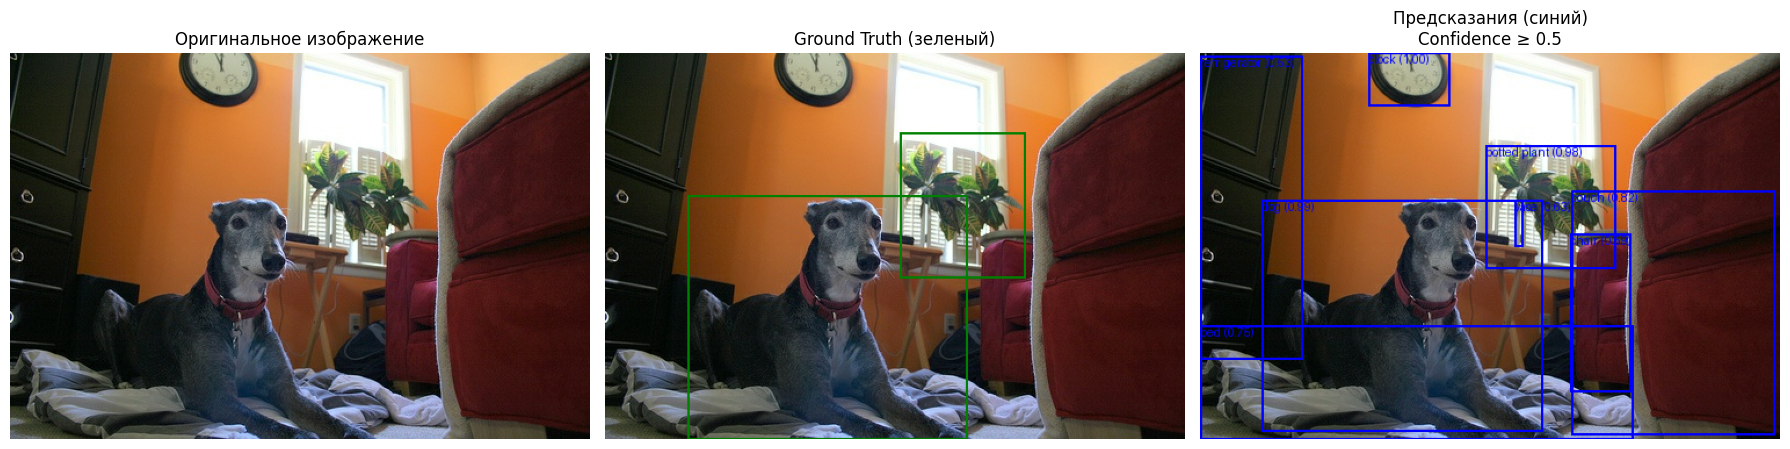

Изображение 1:
  Ground Truth боксов: 2
  Предсказанных боксов: 8
  False Positives: 6
  False Negatives: 0
  True Positives: 2
--------------------------------------------------


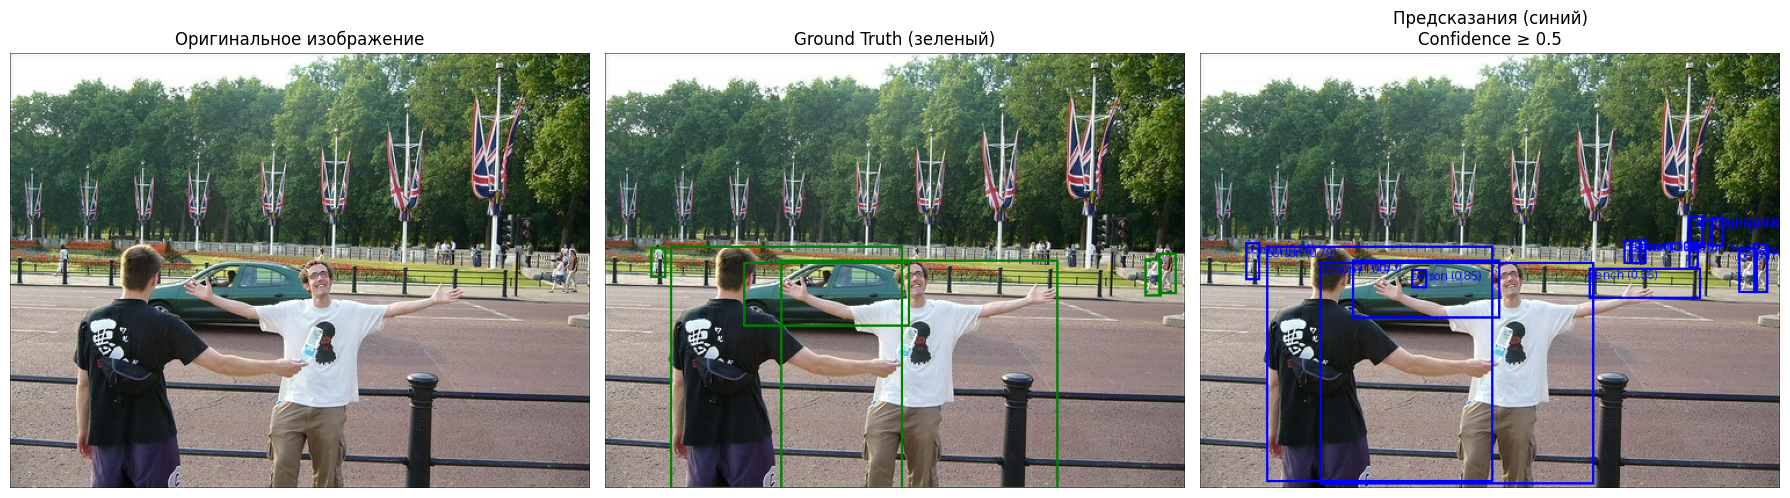

Изображение 2:
  Ground Truth боксов: 6
  Предсказанных боксов: 14
  False Positives: 8
  False Negatives: 0
  True Positives: 6
--------------------------------------------------


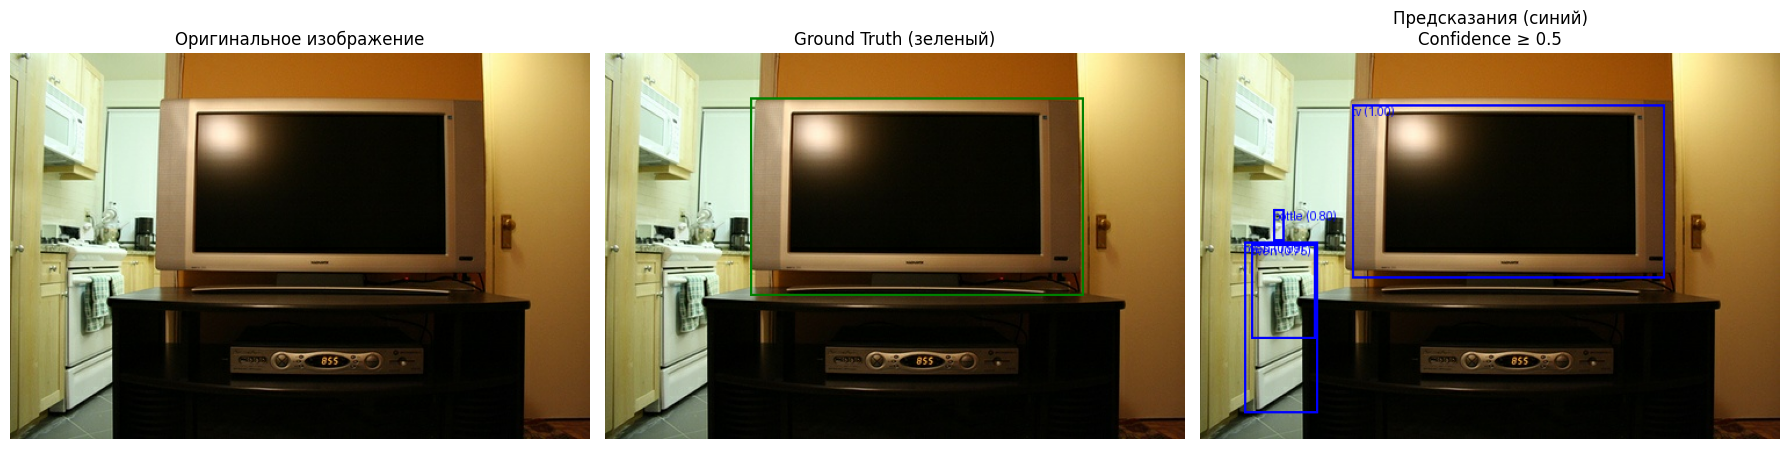

Изображение 3:
  Ground Truth боксов: 1
  Предсказанных боксов: 4
  False Positives: 3
  False Negatives: 0
  True Positives: 1
--------------------------------------------------


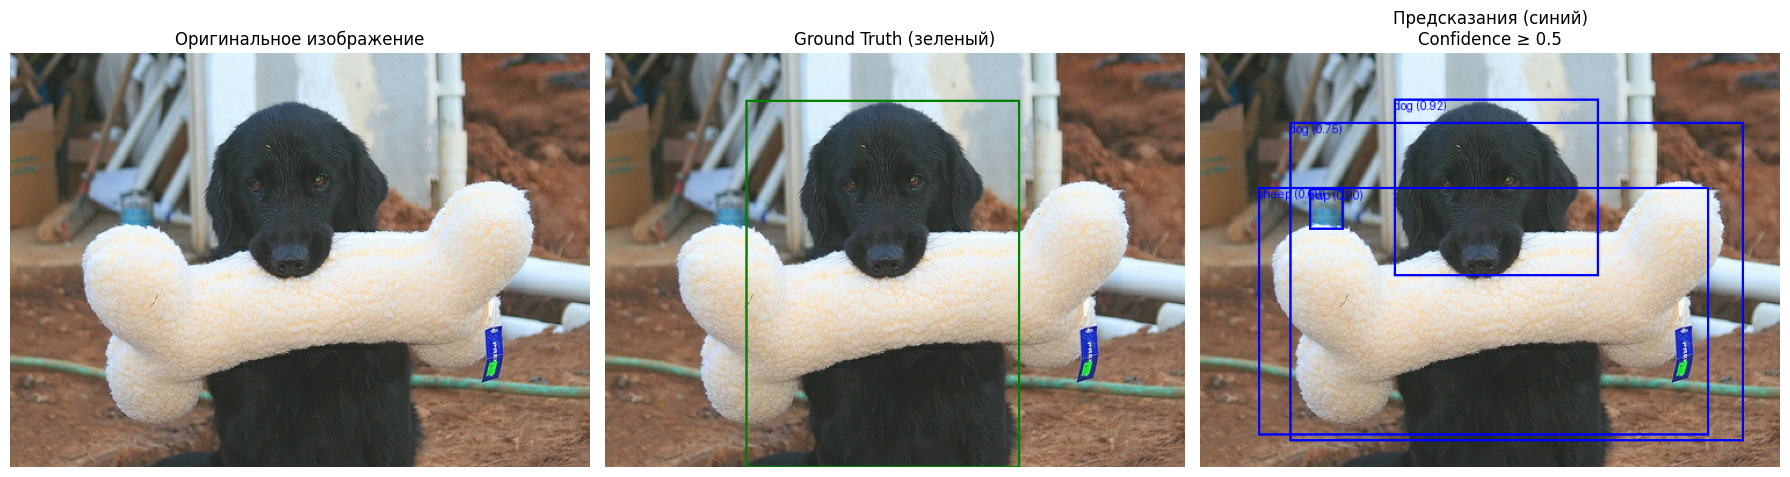

Изображение 4:
  Ground Truth боксов: 1
  Предсказанных боксов: 4
  False Positives: 3
  False Negatives: 0
  True Positives: 1
--------------------------------------------------


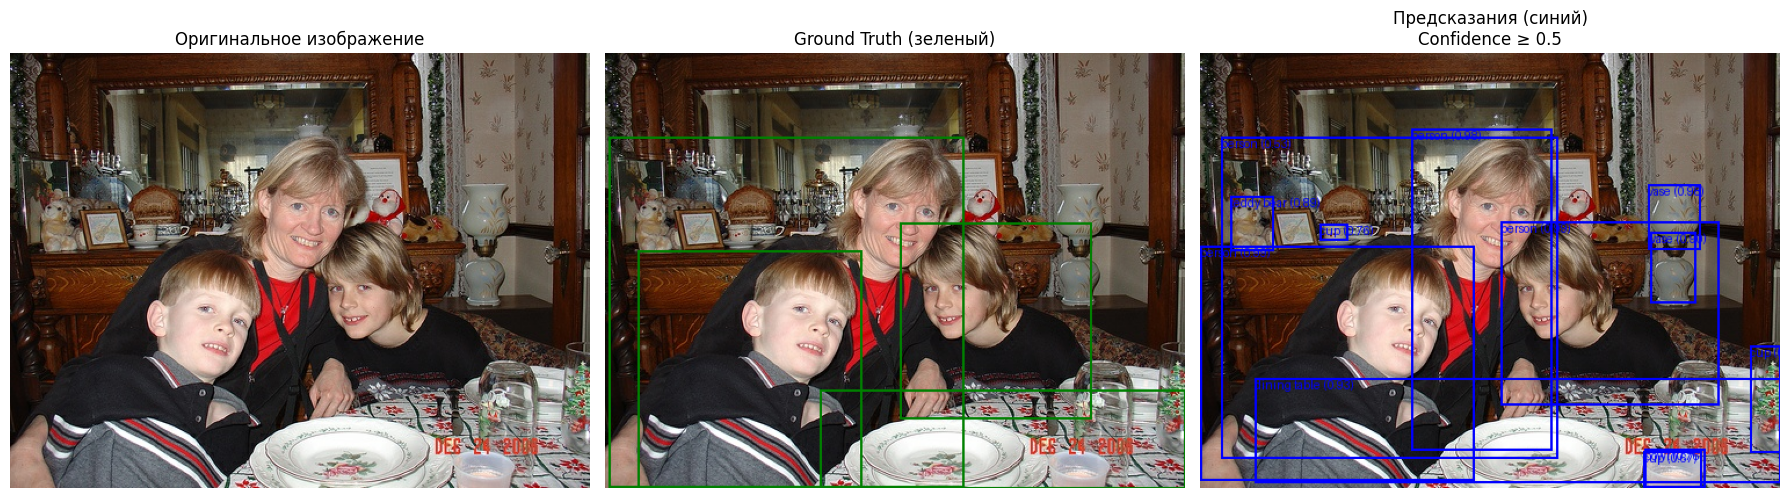

Изображение 5:
  Ground Truth боксов: 4
  Предсказанных боксов: 12
  False Positives: 9
  False Negatives: 1
  True Positives: 3
--------------------------------------------------
Итоговые результаты для 5 изображений:
Всего False Positives: 29
Всего False Negatives: 1


In [62]:
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
N = 5
total_fp = 0
total_fn = 0

print(f"Анализ {N} изображений...")

for i in range(N):
    # Загрузка изображения и его разметки
    image_data = voc_dataset[i]
    image = image_data['image']
    objects = image_data['objects']

    # Получение ground truth bounding boxes
    gt_boxes = []
    for j in range(len(objects['bbox'])):
        bbox = objects['bbox'][j]
        # Конвертация из формата [y_min, x_min, y_max, x_max] в [x_min, y_min, x_max, y_max]
        height, width = image.shape[0], image.shape[1]
        xmin = int(bbox[1] * width)
        ymin = int(bbox[0] * height)
        xmax = int(bbox[3] * width)
        ymax = int(bbox[2] * height)
        gt_boxes.append([xmin, ymin, xmax, ymax])

    gt_boxes = np.array(gt_boxes)

    # Применение трансформаций
    image_tensor = transform_image(image).unsqueeze(0).to(device)

    # Выполнение прямого прохода
    with torch.no_grad():
        outputs = model(image_tensor)

    # Извлекаем bounding boxes, метки и confidence scores из полученных выходов модели
    pred_boxes = outputs[0]['boxes'].cpu().numpy()
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].cpu().numpy()

    # Установите порог confidence_threshold в эмпирическом значении
    confidence_threshold = 0.5

    # Применяем фильтр выходных значений на основе заданного порога
    mask = pred_scores >= confidence_threshold
    filtered_boxes = pred_boxes[mask]
    filtered_labels = pred_labels[mask]
    filtered_scores = pred_scores[mask]

    # Конвертация изображения для визуализации
    pil_image = Image.fromarray(image.astype(np.uint8))

    # Отрисовка bounding boxes с реальной разметкой (зеленый)
    image_with_gt = pil_image.copy()
    for box in gt_boxes:
        draw = ImageDraw.Draw(image_with_gt)
        xmin, ymin, xmax, ymax = map(int, box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline="green", width=2)

    # Отрисовка bounding boxes на изображении с предсказаниями (синий)
    image_with_pred = pil_image.copy()
    for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
        draw = ImageDraw.Draw(image_with_pred)
        xmin, ymin, xmax, ymax = map(int, box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline="blue", width=2)
        class_name = COCO_CLASSES[label] if label < len(COCO_CLASSES) else f"Class_{label}"
        draw.text((xmin, ymin), f"{class_name} ({score:.2f})", fill="blue")

    # Создание комбинированного изображения
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Оригинальное изображение
    ax1.imshow(pil_image)
    ax1.set_title('Оригинальное изображение')
    ax1.axis('off')

    # Ground truth
    ax2.imshow(image_with_gt)
    ax2.set_title('Ground Truth (зеленый)')
    ax2.axis('off')

    # Предсказания
    ax3.imshow(image_with_pred)
    ax3.set_title(f'Предсказания (синий)\nConfidence ≥ {confidence_threshold}')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

    # Вычисление IoU и подсчет FP/FN
    print(f"Изображение {i+1}:")
    print(f"  Ground Truth боксов: {len(gt_boxes)}")
    print(f"  Предсказанных боксов: {len(filtered_boxes)}")

    # Подсчет количества False Positive и False Negative
    iou_threshold = 0.5
    matched_gt = set()
    matched_pred = set()

    # Сопоставление предсказаний с ground truth
    for pred_idx, pred_box in enumerate(filtered_boxes):
        for gt_idx, gt_box in enumerate(gt_boxes):
            iou = calculate_iou(pred_box, gt_box)
            if iou >= iou_threshold and gt_idx not in matched_gt:
                matched_gt.add(gt_idx)
                matched_pred.add(pred_idx)
                break

    fp = len(filtered_boxes) - len(matched_pred)  # False Positives
    fn = len(gt_boxes) - len(matched_gt)          # False Negatives

    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")
    print(f"  True Positives: {len(matched_pred)}")

    total_fp += fp
    total_fn += fn

    print("-" * 50)

print(f"Итоговые результаты для {N} изображений:")
print(f"Всего False Positives: {total_fp}")
print(f"Всего False Negatives: {total_fn}")

#### 2.7 Поиск оптимальной конфигурации

Проанализируйте полученные результаты с выбранным значением фильтрации предсказаний. Проведите исследование с целью поиска оптимального порога и баланса FN/FP. Обоснуйте полученные результаты:


АНАЛИЗ РАЗЛИЧНЫХ ПОРОГОВЫХ ЗНАЧЕНИЙ


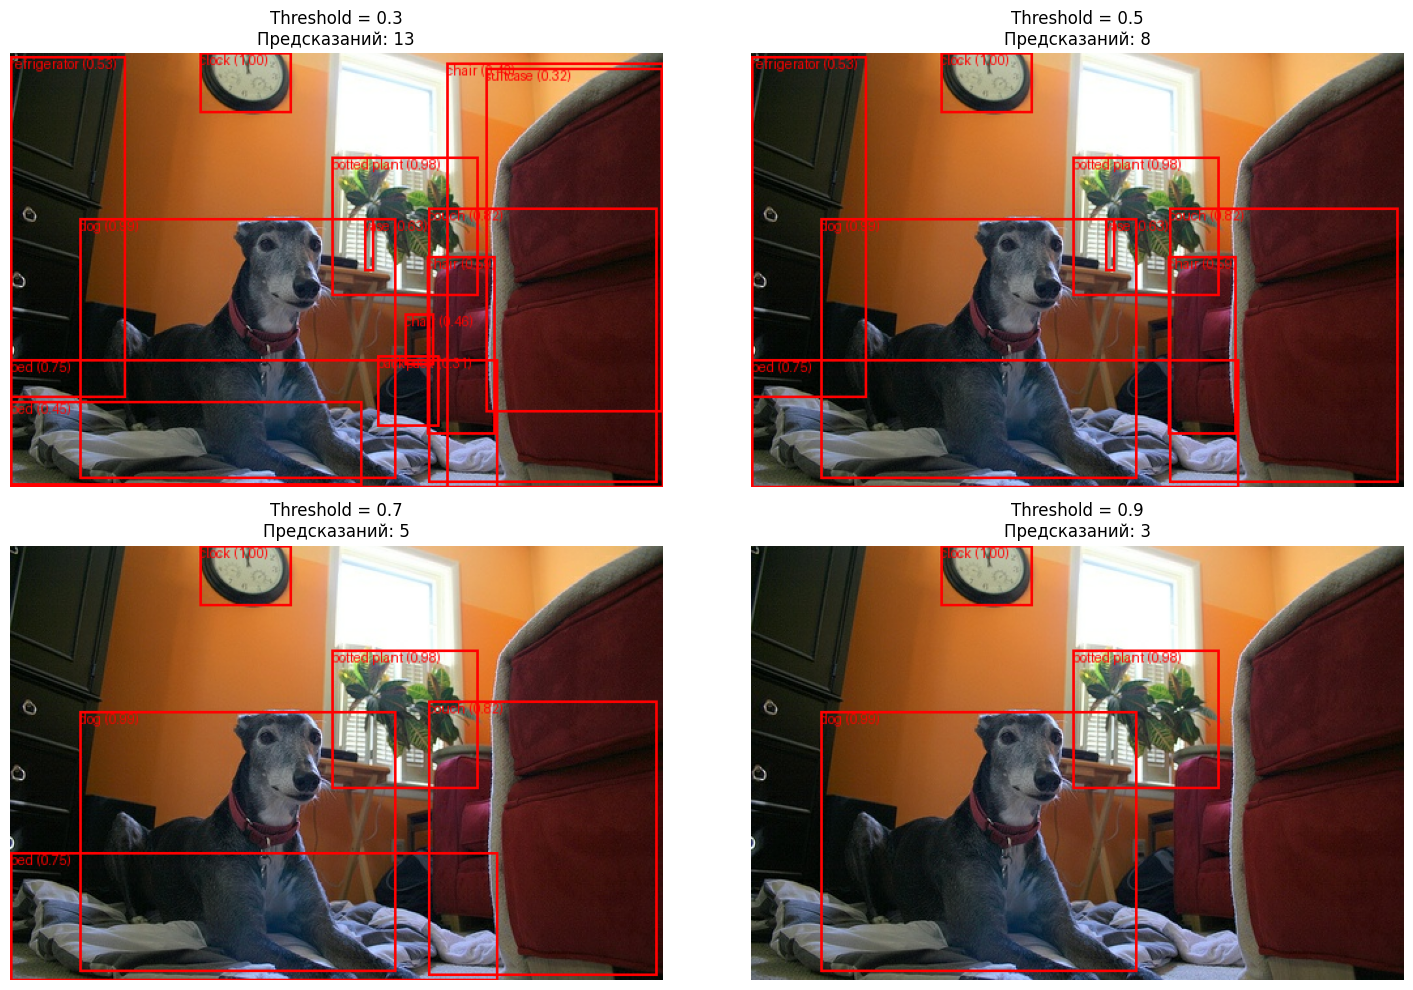


АНАЛИЗ БАЛАНСА FALSE POSITIVE / FALSE NEGATIVE:
Чем ниже порог - больше FP (ложных срабатываний)
Чем выше порог - больше FN (пропущенных объектов)

РЕКОМЕНДАЦИИ:
• Порог 0.3-0.5: Подходит для задач, где важнее не пропустить объекты
• Порог 0.5-0.7: Баланс между точностью и полнотой
• Порог 0.7-0.9: Подходит для задач, где важна высокая точность


In [63]:
print("\n" + "="*50)
print("АНАЛИЗ РАЗЛИЧНЫХ ПОРОГОВЫХ ЗНАЧЕНИЙ")
print("="*50)

# Исследование различных пороговых значений
thresholds = [0.3, 0.5, 0.7, 0.9]
sample_idx = 0  # Анализируем первое изображение

sample = voc_dataset[sample_idx]
image = sample['image']
image_tensor = transform_image(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image_tensor)

pred_boxes = outputs[0]['boxes'].cpu().numpy()
pred_labels = outputs[0]['labels'].cpu().numpy()
pred_scores = outputs[0]['scores'].cpu().numpy()

plt.figure(figsize=(15, 10))

for i, threshold in enumerate(thresholds):
    # Фильтрация предсказаний
    keep_indices = pred_scores >= threshold
    filtered_boxes = pred_boxes[keep_indices]
    filtered_labels = pred_labels[keep_indices]
    filtered_scores = pred_scores[keep_indices]

    # Визуализация
    plt.subplot(2, 2, i+1)
    result_image = Image.fromarray(image.astype(np.uint8))
    result_image = draw_predictions(result_image, filtered_boxes,
                                   [COCO_CLASSES[label] for label in filtered_labels],
                                   filtered_scores, color="red")

    plt.imshow(result_image)
    plt.title(f"Threshold = {threshold}\nПредсказаний: {len(filtered_boxes)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Анализ баланса FP/FN
print("\nАНАЛИЗ БАЛАНСА FALSE POSITIVE / FALSE NEGATIVE:")
print("Чем ниже порог - больше FP (ложных срабатываний)")
print("Чем выше порог - больше FN (пропущенных объектов)")

# Рекомендации по выбору порога
print("\nРЕКОМЕНДАЦИИ:")
print("• Порог 0.3-0.5: Подходит для задач, где важнее не пропустить объекты")
print("• Порог 0.5-0.7: Баланс между точностью и полнотой")
print("• Порог 0.7-0.9: Подходит для задач, где важна высокая точность")

